In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

In [346]:
from skimage.data import horse
from skimage.util import random_noise

X = horse()
Y = random_noise(X, "gaussian", var=0.3)

In [347]:
np.savetxt("../horse.txt", Y)

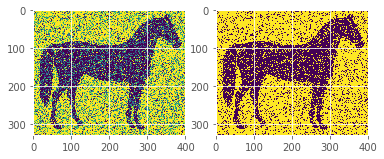

In [352]:
A = np.loadtxt("../denoised.txt").reshape(-1, 400)

_, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(Y)
ax2.imshow(A)

In [278]:
def neighbourhood(M, coords, colour, n=4):
    height, width = M.shape
    i, j = coords

    def neighbours(x, y, n=4):
        # Four neighbour scheme
        neighbours = np.array([(x-1, y), (x, y-1), (x+1, y), (x, y+1)])
        # Eight neighbour scheme
        if n >= 8:
            diagonal = np.array([(x-1, y-1), (x-1, y+1), (x+1, y-1), (x+1, y+1)])
            neighbours = np.vstack([neighbours, diagonal])
        # Twelve neighbour scheme
        if n >= 12:
            extremal = np.array([(x-2, y), (x, y-2), (x+2, y), (x, y+2)])
            neighbours = np.vstack([neighbours, extremal])
        return neighbours

    def boundary(index):
        i, j = index
        # Remove boundary points
        if i < 0 or j < 0:
            return False
        if i >= height or j >= width:
            return False
        return True

    positions = list(filter(boundary, neighbours(i, j, n)))

    neighbour_colours = [M[i, j] for i, j in np.array(positions)]
    same_colours = neighbour_colours.count(colour)

    return same_colours

In [294]:
def neighbourhood4(X, coords, colour):
    height, width = X.shape
    i, j = coords
    same_colours = 0

    if (i-1 > -1 and X[i-1, j] == colour):
        same_colours += 1
    if (i+1 <  height and X[i+1, j] == colour):
        same_colours += 1
    if (j+1 <  width and X[i, j+1] == colour):
        same_colours += 1
    if (j-1 > -1 and X[i, j-1] == colour):
        same_colours += 1

    return same_colours

In [324]:
def mh_sample(Y, n_iter, noise_var=0.3, beta=1):
    n, m = Y.shape
    X = np.random.randint(0, 2, (n, m))

    # Generate a chain of length n_iter
    for k in range(n_iter):
        for i in range(n):
            for j in range(m):
                x_candidate = 1 - X[i,j]
                #x_candidate = np.random.randint(0, 2)

                h           = - 1.0/(2*noise_var) * (Y[i,j] - X[i,j])**2
                h_candidate = - 1.0/(2*noise_var) * (Y[i,j] - x_candidate)**2

                d           = beta * c_neighbour(X, i, j, X[i,j]) + h
                d_candidate = beta * c_neighbour(X, i, j, x_candidate) + h_candidate

                # Acceptance probability
                p = np.exp(min(0, d_candidate - d))
                U = np.random.uniform()
                if U < p:
                    X[i,j] = x_candidate

    return X

CPU times: user 5 s, sys: 476 ms, total: 5.48 s
Wall time: 5.12 s


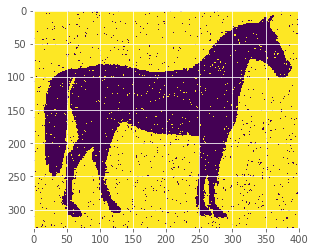

In [353]:
# Standard
%time Q = mh_sample(Y, 5)
plt.imshow(Q)

CPU times: user 5.56 s, sys: 675 ms, total: 6.24 s
Wall time: 5.76 s


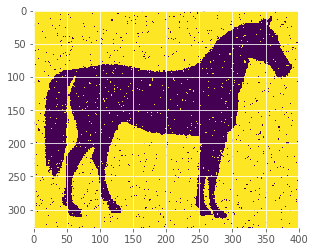

In [295]:
# Fast neighbour
%time Q = mh_sample(Y, 5)
plt.imshow(Q)

In [293]:
%load_ext Cython

In [327]:
%%cython

cimport numpy as np

def c_neighbour(np.ndarray X, int i, int j, int colour):
    cdef int same_colours = 0
    cdef int height, width
    height = X.shape[0]
    width  = X.shape[1]

    if (i-1 > -1 and X[i-1, j] == colour):
        same_colours += 1
    if (i+1 <  height and X[i+1, j] == colour):
        same_colours += 1
    if (j+1 <  width and X[i, j+1] == colour):
        same_colours += 1
    if (j-1 > -1 and X[i, j-1] == colour):
        same_colours += 1

    return same_colours

CPU times: user 4.88 s, sys: 482 ms, total: 5.37 s
Wall time: 5.02 s


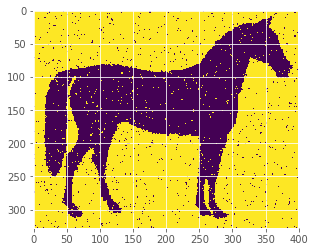

In [328]:
# Fast C neighbour
%time Q = mh_sample(Y, 5)
plt.imshow(Q)

In [333]:
%%cython

cimport numpy as np

def c_neighbour(np.ndarray X, int i, int j, int colour):
    cdef int same_colours = 0
    cdef int height, width
    height = X.shape[0]
    width  = X.shape[1]

    if (i-1 > -1 and X[i-1, j] == colour):
        same_colours += 1
    if (i+1 <  height and X[i+1, j] == colour):
        same_colours += 1
    if (j+1 <  width and X[i, j+1] == colour):
        same_colours += 1
    if (j-1 > -1 and X[i, j-1] == colour):
        same_colours += 1

    return same_colours

def c_mh_sample(np.ndarray Y, int n_iter, float noise_var=0.3, float beta=1):
    cdef int m, n
    n = Y.shape[0]
    m = Y.shape[1]

    cdef np.ndarray X
    X = np.random.randint(0, 2, (n, m))
    
    cdef int x_candidate
    cdef float h, h_candidate
    cdef float d, d_canidate
    cdef float p, U

    # Generate a chain of length n_iter
    for k in range(n_iter):
        for i in range(n):
            for j in range(m):
                x_candidate = 1 - X[i,j]
                #x_candidate = np.random.randint(0, 2)

                h           = - 1.0/(2*noise_var) * (Y[i,j] - X[i,j])**2
                h_candidate = - 1.0/(2*noise_var) * (Y[i,j] - x_candidate)**2

                d           = beta * c_neighbour(X, i, j, X[i,j]) + h
                d_candidate = beta * c_neighbour(X, i, j, x_candidate) + h_candidate

                # Acceptance probability
                p = np.exp(min(0, d_candidate - d))
                U = np.random.uniform()
                if U < p:
                    X[i,j] = x_candidate

    return X

CPU times: user 5.05 s, sys: 214 ms, total: 5.26 s
Wall time: 5.15 s


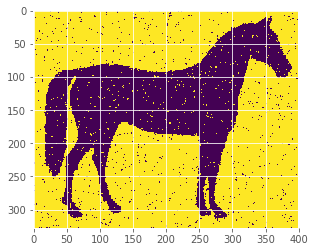

In [334]:
%time Q = c_mh_sample(Y, 5)
plt.imshow(Q)